Neural networks that classify images are usually based on a process called [convolution](https://en.wikipedia.org/wiki/Convolution) (a kind of filtering), so they are called [convolutional neural networks](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNNs or ConvNets). CNNs were initially developed for tasks like speech recognition, but in the late 90s Yann LeCun developed a net with high accuracy on the recognition of handwritten digits.

This network, or a similar one, is used regularly for reading the digits on handwritten checks and mail.

One of the more recent breakthroughs in image classification is on the [ImageNet recognition task](image-net.org/challenges/LSVRC/2012/browse-synsets). In 2012, Krizhevsky et al. got a 40% error rate ("top-1 error") for classification of objects from 1000 categories, using a CNN with more layers than previously. At the end of 2015, that error has dropped to 19% with research from [He et al.](http://arxiv.org/abs/1512.03385) at Microsoft, and 17% with work from [Szegedy et al.](http://arxiv.org/abs/1512.00567). You can see a picture of some different network architectures from 1998 to 2015 here: [Visualizing CNN architectures side by side with mxnet](http://josephpcohen.com/w/visualizing-cnn-architectures-side-by-side-with-mxnet/).

One of the best ways to understand what's going on inside a CNN is to [visualize the states at different layers](https://www.youtube.com/watch?v=AgkfIQ4IGaM). Andrej Karpathy has a great post describing [more things you can do with CNNs](http://cs231n.github.io/understanding-cnn/).

In this example we will use TensorFlow to label an image and compare similarity in two different ways.

First, we load TensorFlow and other libraries we will need.

In [1]:
import os.path
import numpy as np
import tensorflow as tf
import tensorflow.python.platform
from tensorflow.python.platform import gfile
import matplotlib.pyplot as plt
%matplotlib inline

Then we set up some variables to keep track of where the model files are, and load the model. This Inception-v3 network is almost 100MB and should have a 21% top-1 error, and 5% top-5 error.

In [2]:
model_dir = '../../models/inceptionv3'
model_labels = os.path.join(model_dir, 'imagenet_comp_graph_label_strings.txt')
model_file = os.path.join(model_dir, 'tensorflow_inception_graph.pb')
def create_graph(model_file):
  with gfile.FastGFile(model_file, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')
%time create_graph(model_file)

CPU times: user 520 ms, sys: 90 ms, total: 610 ms
Wall time: 809 ms


Now we define a function that can load and process our images, with one flag that tells it whether to extract output from the final output of the network, or just before the final output. We'll get back to that in a moment.

In [3]:
def run_inference_on_image(image, coded=False):
  image_data = gfile.FastGFile(image, 'rb').read()
  with tf.Session() as sess:
    tensor = sess.graph.get_tensor_by_name('pool_3:0' if coded else 'softmax:0')
    predictions = sess.run(tensor, {'DecodeJpeg/contents:0': image_data})
    return predictions.reshape(-1)

Running this code on an image looks like this:

In [4]:
%time result = run_inference_on_image('hopper.jpg')

CPU times: user 1e+03 ms, sys: 280 ms, total: 1.28 s
Wall time: 767 ms


And we can see the classification vector it returns has 1008 elements (not sure why it's 1008 instead of 1000).

In [5]:
print result
result.shape

[  1.48403575e-04   1.19196273e-04   6.89569642e-05 ...,   1.48403575e-04
   1.48403284e-04   1.48403284e-04]


(1008,)

If we plot the vector we can see one peak and a few smaller peaks.

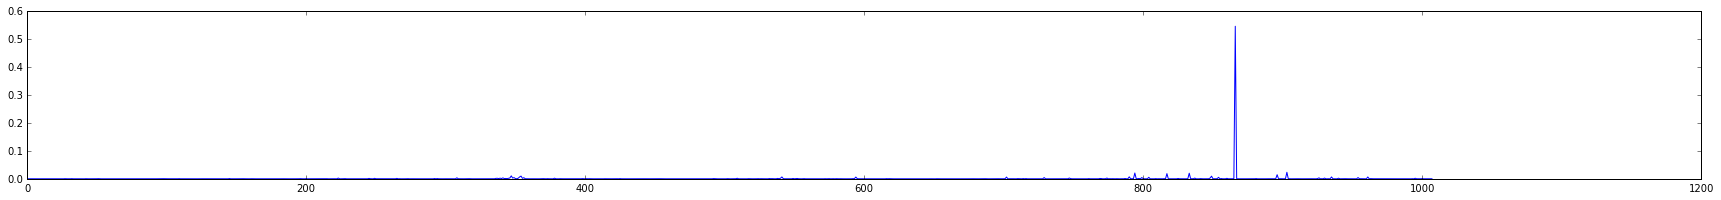

In [6]:
plt.figure(figsize=[30, 3])
plt.plot(result)
plt.show()

To figure out what the name of this category is, we need to load the category names (also called synset names).

In [7]:
labels = []
with open(model_labels) as f:
    for label in f.readlines():
        labels.append(label.strip())
len(labels)

1001

Then we can use `argmax()` to find the index of that peak, and look up the word at that index.

In [8]:
labels[result.argmax()]

'military uniform'

Let's look up vectors for a few more images.

In [9]:
hopper = run_inference_on_image('hopper.jpg')
military = run_inference_on_image('military.jpg')
obama = run_inference_on_image('obama.jpg')

If we plot all three of these we can see that Grace Hopper and the person in military drab have similar peaks (green and blue) but President Obama does not.

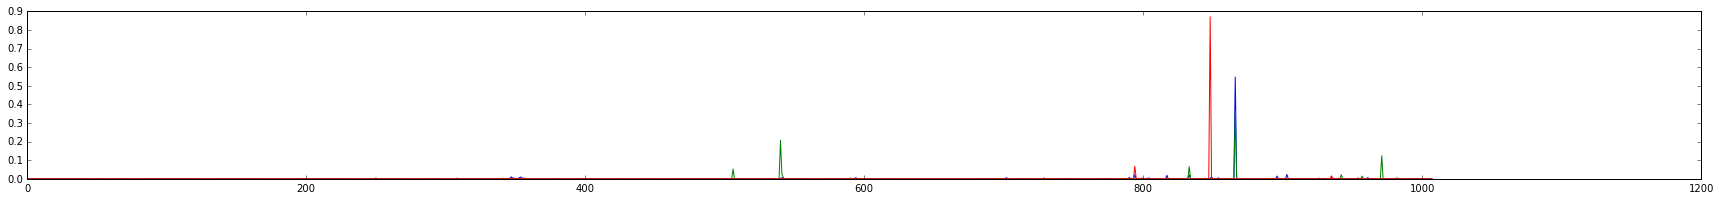

In [10]:
plt.figure(figsize=[30, 3])
plt.plot(hopper)
plt.plot(military)
plt.plot(obama)
plt.show()

What are the names of these categories?

In [11]:
print labels[hopper.argmax()]
print labels[military.argmax()]
print labels[obama.argmax()]

military uniform
military uniform
groom


Let's compare the similarity between the three images.

In [12]:
print np.square(hopper - military).sum()
print np.square(hopper - obama).sum()
print np.square(obama - military).sum()

0.0979673
1.05706
0.965004


Grace Hopper and the military person are very similar (small square difference), but the other pairs are all different. Instead of using the final output for comparison, we can compare at a slightly higher level: the layer just before the output. Andrej Karpathy has a great example of this where he uses these "codes" for a visualization of a huge set of images: [t-SNE visualization of CNN codes](http://cs.stanford.edu/people/karpathy/cnnembed/).

In [13]:
hopper_code = run_inference_on_image('hopper.jpg', coded=True)
military_code = run_inference_on_image('military.jpg', coded=True)
obama_code = run_inference_on_image('obama.jpg', coded=True)

If we plot these codes, they're a lot messier. So to try and get some structure we will sort them all by one of the codes. You can vaguely see that the red line is rising from left to right (following the blue line), but the green line stays consistently random.

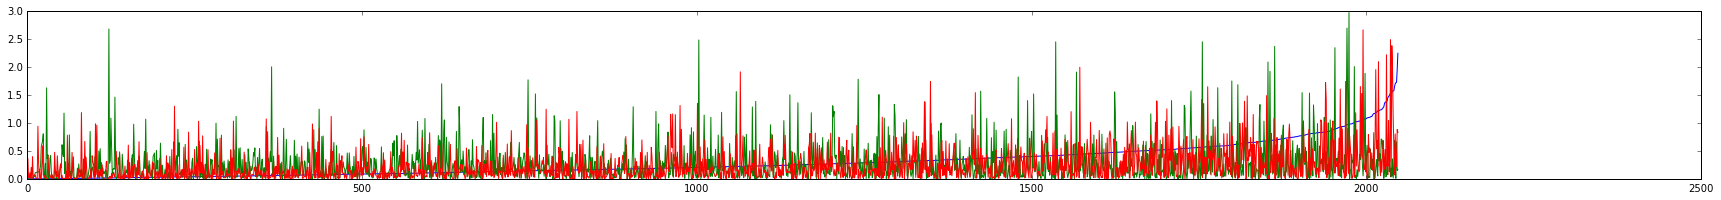

In [14]:
plt.figure(figsize=[30, 3])
plt.plot(sorted(zip(hopper_code, military_code, obama_code)))
plt.show()

The blue line is Grace Hopper and the red line is President Obama. One way to read this is that while the category/label of Grace Hopper and the military person are very similar, the content of the President Obama photo is much more similar to the content of the Grace Hopper photo.

In [15]:
print np.square(hopper_code - military_code).sum()
print np.square(hopper_code - obama_code).sum()
print np.square(obama_code - military_code).sum()

346.055
238.747
426.089
